In [98]:
import numpy as np 
from numpy import array
import pandas as pd 
from sklearn import datasets
import statistics
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import metrics

# Setosa, Versicolour, and Virginica
# 0, 1 or 2
iris = datasets.load_iris()
# Sepal Length, Sepal Width, Petal Length and Petal Width
# TODO rita one roc curve on each combination
X = iris.data[:100, :]  # taking all 4 attributes within Setosa and Versicolour flower only
y = iris.target[ : 100] # taking only the Setosa and Versicolour flowers




1.39248056e+94


In [84]:
# TODO have posDistrList as global variable
def fit(X, y):
    # Get the amount of different features e.g, 4
    nrOfFeatures = np.size(X, axis=1)
    # Make y shape == X shape
    yReshaped = np.reshape(y, (np.size(y), 1))
    # Append label to each featurevector
    dataset = np.append(X, yReshaped, axis=1)
    print("a dataset row: ", dataset[32])
    # Find the labels e.g [1, 0]
    classes = list(set(y))
    classes.sort(reverse=True)
    print("different classes:", classes)
    # Separate the classes into positives and negatives
    # Where 1 represent the positive class and vice versa
    filterPositiveFeatureVectors = dataset[:, -1] == classes[0]
    filterNegativeFeatureVectors = dataset[:, -1] == classes[1]
    positiveFeatureVectors = dataset[filterPositiveFeatureVectors]
    negativeFeatureVectors = dataset[filterNegativeFeatureVectors] 
    # Slicing away the labels
    posFeatureMatrix = positiveFeatureVectors[:, : -1]
    negFeatureMatrix = negativeFeatureVectors[:, : -1]
    # Transposing the matrix to sort the same kind of feature in the same vectors
    # [f0:[1,5,9,13,17,19,21,23,25], f1:[2,6,10,14,18,20,22,24], ...]
    posFeatureMatrixTransposed = np.transpose(posFeatureMatrix)
    negFeatureMatrixTransposed = np.transpose(negFeatureMatrix)
    # Calculating the normal distribution on all feature vectors
    # Placing them in two separate distribution lists
    # TODO why using gaussian naive bayes ? 
    posDistrList = list(map(statistics.NormalDist.from_samples, posFeatureMatrixTransposed))
    print(posDistrList)
    negDistrList = list(map(statistics.NormalDist.from_samples, negFeatureMatrixTransposed))
    print(negDistrList)

    return posDistrList, negDistrList



In [85]:
# Bayes theorem to calculate probabilty with the trained distributions. 
# Using pdf as refered to Probability density function from the normal distributions.
# As instructed in https://docs.python.org/3/library/statistics.html at the bottom.
# Skipping the evidence P(data) factor, because it is just a constant over all the factors which is redundant.
def calculatePosterior(featureVector, distrList, prior):
    posterior = prior
    for feature, distrObj in zip(featureVector, distrList):
        posterior *= distrObj.pdf(feature)
    return posterior

# returns [[negProb, posProb], [negProb, posProb], [negProb, posProb]...]
# newDataMatrix: [[5.2, 4.1, 1.5, 0.1], [5.2, 4.1, 1.5, 0.1] ...]
# posDistr: [obj, obj, obj, obj]
def predictMatrix(newDataMatrix, posDistrList, negDistrList):
    # posteriorPos = 0.5 * posDistrList[0].pdf(5.2) * posDistrList[1].pdf(4.1)...
    # posteriorNeg = 0.5 * negDistrList[0].pdf(5.2) * negDistrList[1].pdf(4.1)...
    # -> [negProb, posProb]
    
    posProbVector = np.array([])
    negProbVector = np.array([])
    for vector in newDataMatrix:
        posPosterior = calculatePosterior(vector, posDistrList, 0.5)
        negPosterior = calculatePosterior(vector, negDistrList, 0.5)
        posProbVector = np.append(posProbVector, posPosterior)
        negProbVector = np.append(negProbVector, negPosterior)
    probaMatrix = np.stack((negProbVector, posProbVector), axis=1)
    #print("probamatrix:: ", probaMatrix)
    return probaMatrix

In [98]:
def true_false_positive(threshold_vector, y_test):
    # predicted class 1, actual class 1
    true_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 1)
    true_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 0)
    false_positive = np.equal(threshold_vector, 1) & np.equal(y_test, 0)
    false_negative = np.equal(threshold_vector, 0) & np.equal(y_test, 1)

    tpr = true_positive.sum() / (true_positive.sum() + false_negative.sum())
    fpr = false_positive.sum() / (false_positive.sum() + true_negative.sum())

    return tpr, fpr

In [119]:
def calculateTprFpr(scoreMatrix):
    # extract truths
    # extract score
    scoreVector = scoreMatrix[:, 0]
    truthVector = scoreMatrix[:, -1]
    maxScore = max(scoreVector)
    minScore = min(scoreVector)
    thresholdLow = np.arange(minScore, 1.0, (1.0-minScore)/50.0)
    thresholdHigh = np.arange(1.0, maxScore, (maxScore-1.0)/50.0)
    thresholdVector = np.append(thresholdLow, thresholdHigh)
    print("thresholdvector:: ", thresholdVector, "len: ", len(thresholdVector))
    # thresholdVector: [0.1, 0.01, 0.001...]
    # scoreMatrix: [[score, y], [score, y] ...100]
    #scoreMatrix = [[1, 0], [2, 1], [3, 0]]
    tprVector = np.array([])
    fprVector = np.array([])
    
    for threshold in thresholdVector:
        true_positive = np.greater_equal(scoreVector, threshold) & np.equal(truthVector, 1) # predicted class 1, actual class 1
        true_negative = np.less_equal(scoreVector, threshold) & np.equal(truthVector, 0) # predicted class 0, actual class 0
        false_positive = np.greater_equal(scoreVector, threshold) & np.equal(truthVector, 0) # predicted class 1, actual class 0
        false_negative = np.less_equal(scoreVector, threshold) & np.equal(truthVector, 1) # predicted class 0, actual class 1
        tpr = np.round(np.divide(true_positive.sum(), (true_positive.sum() + false_negative.sum())), 5)
        if(np.isnan(tpr)):
            tpr = 0
        fpr = np.round(np.divide(false_positive.sum(), (false_positive.sum() + true_negative.sum())), 5)
        if(np.isnan(fpr)):
            fpr = 0   
        tprVector = np.append(tprVector, tpr)
        fprVector = np.append(fprVector, fpr)

    print("tprVector::: ",tprVector[0: 200])
    print("fprVector::: ",fprVector[0: 200])

    return tprVector, fprVector

In [87]:
def drawROC(tprVector, fprVector):
    areaUnderCurve = metrics.auc(fprVector, tprVector)
    plt.plot(fprVector, tprVector, label='ROC curve (area = %.2f)' %areaUnderCurve)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random guess')
    plt.title('ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid()
    plt.legend()
    plt.show()

a dataset row:  [5.5 4.2 1.4 0.2 0. ]
different classes: [1, 0]
[NormalDist(mu=5.963636363636363, sigma=0.5305069576690833), NormalDist(mu=2.784090909090909, sigma=0.31544961033359903), NormalDist(mu=4.302272727272728, sigma=0.45417373807297545), NormalDist(mu=1.3295454545454546, sigma=0.20297731051403137)]
[NormalDist(mu=5.015217391304348, sigma=0.33397763817646897), NormalDist(mu=3.441304347826087, sigma=0.37981052993215314), NormalDist(mu=1.4695652173913043, sigma=0.177475588577874), NormalDist(mu=0.25, sigma=0.10903618155864084)]
ScoretruthMatrix::  [[8.93448972e-18 0.00000000e+00]
 [2.57406587e-18 0.00000000e+00]
 [1.87943971e-18 0.00000000e+00]
 [2.24213873e-18 0.00000000e+00]
 [4.85129623e+80 1.00000000e+00]
 [1.32653587e+95 1.00000000e+00]
 [1.38169718e+58 1.00000000e+00]
 [5.59173285e+67 1.00000000e+00]
 [6.52163302e+61 1.00000000e+00]
 [1.19852954e+27 1.00000000e+00]]
a dataset row:  [4.9 3.1 1.5 0.2 0. ]
different classes: [1, 0]
[NormalDist(mu=5.911627906976744, sigma=0.527

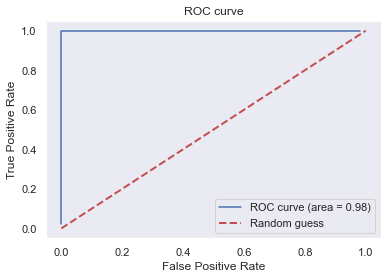

In [120]:
# Cross validation 
k = 10
kf = KFold(n_splits=k, random_state=None, shuffle=True)

partitions = 10
sns.set()

scoreMegaVector = np.array([])
for train_i, test_i in kf.split(X):
    X_train = X[train_i, :]
    y_train = y[train_i]
    X_test = X[test_i, : ]
    y_test = y[test_i]

    # Training the iris dataset, where normal distributions are calculated.
    posDistrList, negDistrList = fit( X_train, y_train)
    
    # TODO Make predict to return array of probablities
    # Predicts class: returns [[negProb, posProb], [negProb, posProb], [negProb, posProb] ...10]
    probaMatrix = predictMatrix(X_test, posDistrList, negDistrList)
    #print("x_test: ", X_test)
    #print("y_test", y_test)
    #print("proba matrixe: ", probaMatrix)

    # Score = pos proba / neg proba
    # score: [score1, score2, score3...10]
    score = np.apply_along_axis(lambda probaVector: probaVector[1]/probaVector[0], 1, probaMatrix)
    #print("SCORE vector::: ", score)
    # y_test: [1,0,0,1,0 ...10]
    # Append truthvalue to each score
    # scoreTruthMatrix: [[score, y], [score, y], ...10]
    scoreTruthMatrix = np.stack((score, y_test), axis=1)
    print("ScoretruthMatrix:: ", scoreTruthMatrix)

    scoreMegaVector = np.append(scoreMegaVector, scoreTruthMatrix)

# reshape megaVector to Matrix: [[score, y], [score, y] ...100]
scoreMegaMatrix = scoreMegaVector.reshape(-1, 2)

tprVector, fprVector = calculateTprFpr(scoreMegaMatrix)
# print roc curve
drawROC(tprVector, fprVector)


  
    

